# Open3D C++ and Python Interaction

For this tutorial we will be using the plane segmentation algorithm in Open3D. You can already see an example on the [official documentation](http://www.open3d.org/docs/latest/tutorial/Basic/pointcloud.html#Plane-segmentation)

## Load the data

We are using the first scan of the sequence 07 of the KITTI dataset, just because

In [1]:
import open3d as o3d
import open3d_jupyter_draw_geometries

In [2]:
# Read one scan from KITTI
filename = './kitti_seq_07_scan_000000.ply'
pcd = o3d.io.read_point_cloud(filename)

# Custom Visualization Viewpoint for this particular scan
front=[-0.86, -0.13, 0.49]
lookat=[2.53, 1.12, -5.31]
up=[0.49, 0.05, 0.87]
zoom=0.1

## Initial inspection of the data

KITTI Sequence 07 scan:


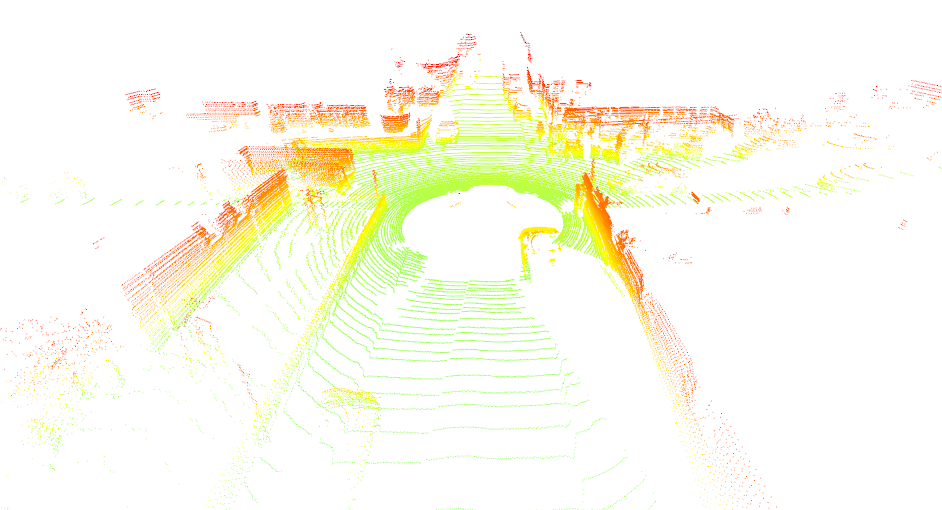

In [3]:
print("KITTI Sequence 07 scan:")
o3d.visualization.draw_geometries([pcd],
                                  front=front, 
                                  lookat=lookat,
                                  up=up,
                                  zoom=zoom)

## Inspect the Segmentation algorithm

You could read the offical documentation as well, or check the implementation but let's use python for this

In [4]:
o3d.geometry.PointCloud.segment_plane?
help(o3d.geometry.PointCloud.segment_plane)

Help on instancemethod in module open3d.cpu.pybind.geometry:

segment_plane(...)
    segment_plane(self, distance_threshold, ransac_n, num_iterations)
    
    Segments a plane in the point cloud using the RANSAC algorithm.
    
    Args:
        distance_threshold (float): Max distance a point can be from the plane model, and still be considered an inlier.
        ransac_n (int): Number of initial points to be considered inliers in each iteration.
        num_iterations (int): Number of iterations.
    
    Returns:
        Tuple[numpy.ndarray[float64[4, 1]], List[int]]



## Parameter tunning

As you can see there are 3 parameters to tune here:
 - **`distance_threshold`** defines the maximum distance a point can have to an estimated plane to be considered an inlier
 - **`ransac_n`** defines the number of points that are randomly sampled to estimate a plane
 - **`num_iterations`** defines how often a random plane is sampled and verified. 
 
The function then returns the plane as $(a,b,c,d)$ such that for each point $(x,y,z)$ on the plane we have $ax + by + cz + d = 0$. The function further returns a list of indices of the inlier points.

## Utility function

This is the main function of our notebook, modify it as you wish

In [5]:
def segment_and_visualize_point_cloud(pcd,
                                      # Default params taken from Open3D implementation
                                      distance_threshold=0.01,
                                      ransac_n=3,
                                      num_iterations=100):
    _, plane_points = pcd.segment_plane(distance_threshold=distance_threshold,
                                        ransac_n=ransac_n,
                                        num_iterations=num_iterations)

    plane_cloud = pcd.select_by_index(plane_points)
    plane_cloud.paint_uniform_color([1, 0, 0])

    rest_cloud = pcd.select_by_index(plane_points, invert=True)
    rest_cloud.paint_uniform_color([0, 0, 1])

    o3d.visualization.draw_geometries([plane_cloud, rest_cloud],
                                      front=front,
                                      lookat=lookat,
                                      up=up,
                                      zoom=zoom)
    return plane_cloud, rest_cloud

## Default parameters

A good starting point is always to use the default params from Open3D and inspect the results:

Results of the plane segmentation with default parameters:


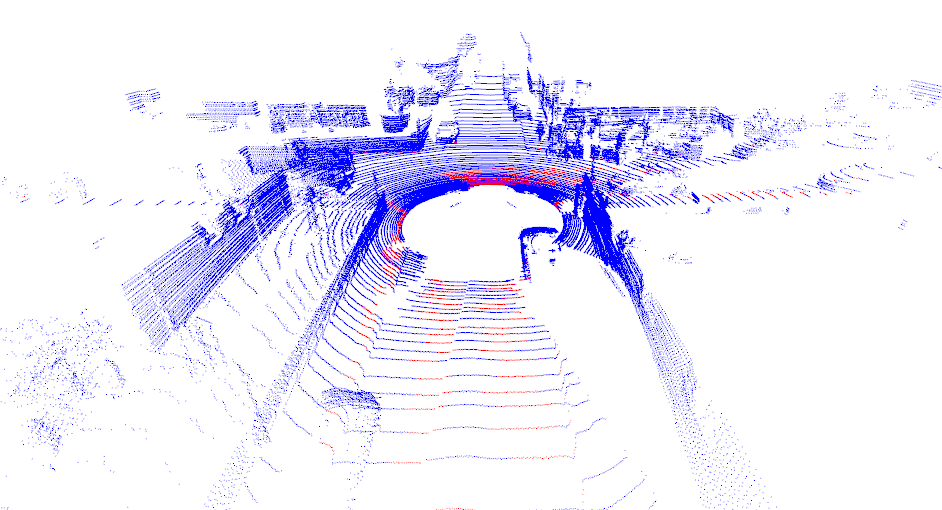

(PointCloud with 7623 points., PointCloud with 115003 points.)

In [6]:
print("Results of the plane segmentation with default parameters:")
segment_and_visualize_point_cloud(pcd)

## Improve results, without compiling code

As you can see, the results are not optimal. With a little effort and just re-running the cell above I found the following parameters to work better:

Results of the plane segmentation with custom parameters:


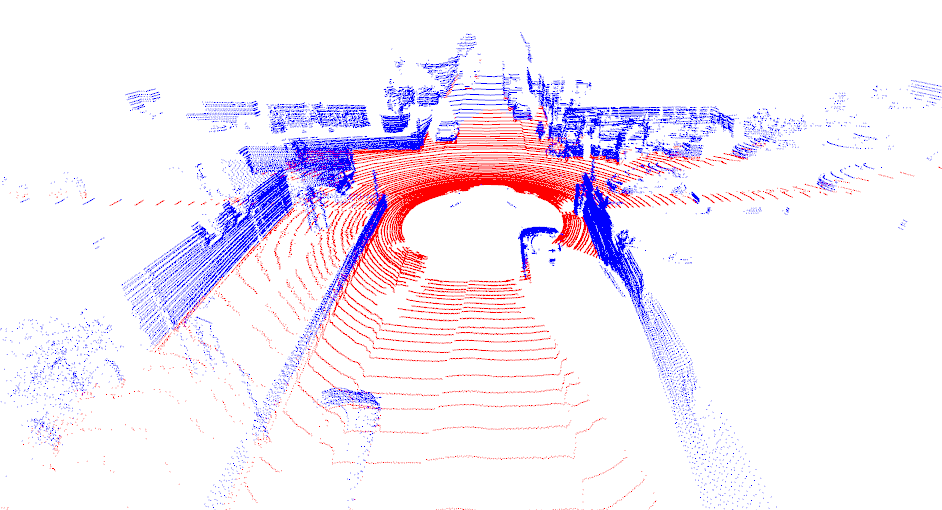

In [7]:
# Custom params
distance_threshold = 0.2
ransac_n = 3
num_iterations = 1000

print("Results of the plane segmentation with custom parameters:")
plane_cloud, rest_cloud = \
    segment_and_visualize_point_cloud(pcd, distance_threshold, ransac_n, num_iterations)

## Improve visualization

To better analyze the results we can improve the visualization by only showing the plane points:

Plane cloud only:


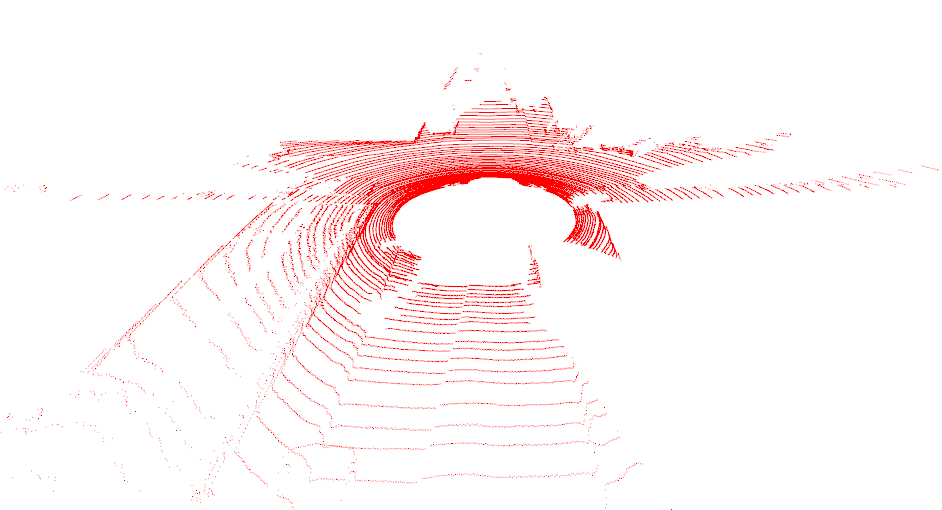

In [8]:
print("Plane cloud only:")
o3d.visualization.draw_geometries([plane_cloud],
                                  front=front,
                                  lookat=lookat,
                                  up=up,
                                  zoom=zoom)

## Report 

In [9]:
total_n_points = len(pcd.points)
planar_n_points = len(plane_cloud.points)
rest_n_points = len(rest_cloud.points)

print("Original cloud had {} points".format(total_n_points))
print("Plane cloud has {} points".format(planar_n_points))
print("Plane cloud represents {} % of the original cloud".format(
    int(100 * planar_n_points / total_n_points)))

Original cloud had 122626 points
Plane cloud has 54926 points
Plane cloud represents 44 % of the original cloud


## Simple benchmark

One thing you can try right away on Jupyter notebooks is to "benchmark" the method. This doesn't replace a real benchmarking but at least will give you an idea of how fast/slow is the method. Just add `%%timeit` at the top of the cell

In [10]:
%%timeit
_, plane_points = pcd.segment_plane(distance_threshold=distance_threshold,
                                    ransac_n=ransac_n,
                                    num_iterations=num_iterations)

1.49 s ± 31.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Timing analysis

As you can see, if this algorithm is taking around `1.5 seconds` on a multicore desktop CPU, it will be very likely that you will be able to run this out of the box on an embedded platform. When you use the Open3D C++ API you will gain some extra miliseconds on the execution but it won't be much. If you reach this point without compiling any C++ file, then you already saved quite lot of time, since during the prototyping stage you were able to draw some conclusions without writing "real code", congratulations!

## Attempt to optimze the runtime.

One thing you could easily do is to change the parameters inside the notebook and re-try the cell until you reach a compromise between the runtime and the results. For example if you change the `num_itearation` to `100`, you will get simillar results and the runtime will be 10 times faster! Check it!

## C++ API

Even when this won't be able to run on a real system, let's use the same parameters we obtained by expermentation on this notebook and create a small C++ application that recreates the same data pipeline. Now let's open [PointCloud](./PlaneSegmentation.cpp)

**NOTE:** At this point you can close the notebook and work as usual on your text editor and on the shell. Just for the sake of completion I added the commands here to also inspect the output.

## Build the C++ application

In [11]:
!mkdir -p build && cd build && cmake .. && make

-- Configuring done
-- Generating done
-- Build files have been written to: /home/ivizzo/dev/examples/open3d_cpp_python/build
[100%] Built target PlaneSegmentation


## Run the C++ application

Note that with the `{}` syntax we can pass variables we created on this notebook to the C++ application, just to test that it's doing what we want it to do

In [ ]:
!./PlaneSegmentation \
    {filename} \
    {distance_threshold} \
    {ransac_n} \
    {num_iterations} \

[Open3D DEBUG] Format auto File ./kitti_seq_07_scan_000000.ply
[Open3D DEBUG] Read geometry::PointCloud: 122626 vertices.
[Open3D DEBUG] [RemoveNonFinitePoints] 0 nan points have been removed.
[Open3D INFO] Visualizing KITTI Sequence 07 scan
[Open3D DEBUG] GLFW init.
[Open3D DEBUG] Add geometry and update bounding box to [(-73.8572, -72.0303, -7.3770) - (76.3938, 62.5950, 2.7931)]
[Open3D DEBUG] Global colormap init.


## C++ Benchmark

If you inspect the last log you can spot this line
```
[Open3D INFO] SegmentPlane took 1507.48 ms.
```

As expected, the C++ is not **much faster** than the Python, this is because we you are calling the python function you are basically calling the exact same C++ implementation, and that's the where the power of Open3D lies, the interoperability between the 2 languagues.